In [22]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


In [23]:
# Read the data from the hdf5 file
with h5py.File('../test_data.h5', 'r') as f:
    data = f['data'][:]
    t = data[0]
    I = data[1]
    Q = data[2]
    # Metadata
    column_names = f['data'].attrs['column_names']
    column_units = f['data'].attrs['column_units']

Data shape: (500, 2)
Covariance matrix:
[[11479.23394996   -53.84669936]
 [  -53.84669936 12209.83931514]]


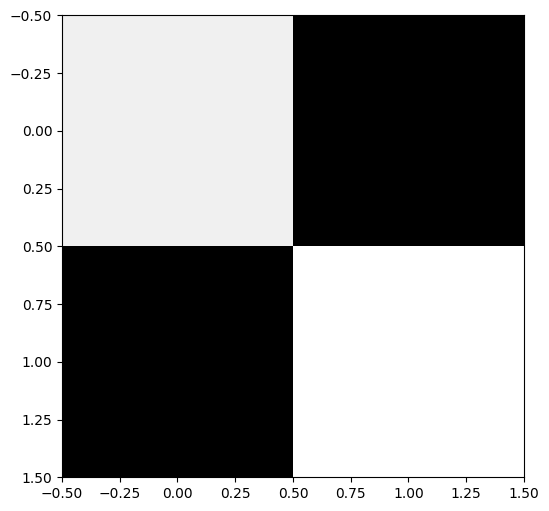

In [29]:
I_centered = I - np.mean(I)
Q_centered = Q - np.mean(Q)

# Stack into matrix form
X = np.stack((I_centered, Q_centered), axis=1)
print("Data shape:", X.shape)

# Covariance matrix
cov = np.cov(X, rowvar=False)
print("Covariance matrix:")
print(cov)
# plot covariance matrix
plt.figure(figsize=(8, 6))
plt.imshow(cov, cmap='gray', interpolation='nearest')

# Whitening
eigvals, eigvecs = np.linalg.eigh(cov)
W = eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T
X_whitened = X @ W.T

# Extract corrected I and Q
I_corrected, Q_corrected = X_whitened[:, 0], X_whitened[:, 1]

# Rescale to original mean
I_corrected = I_corrected * np.std(I) + np.mean(I)
Q_corrected = Q_corrected * np.std(Q) + np.mean(Q)


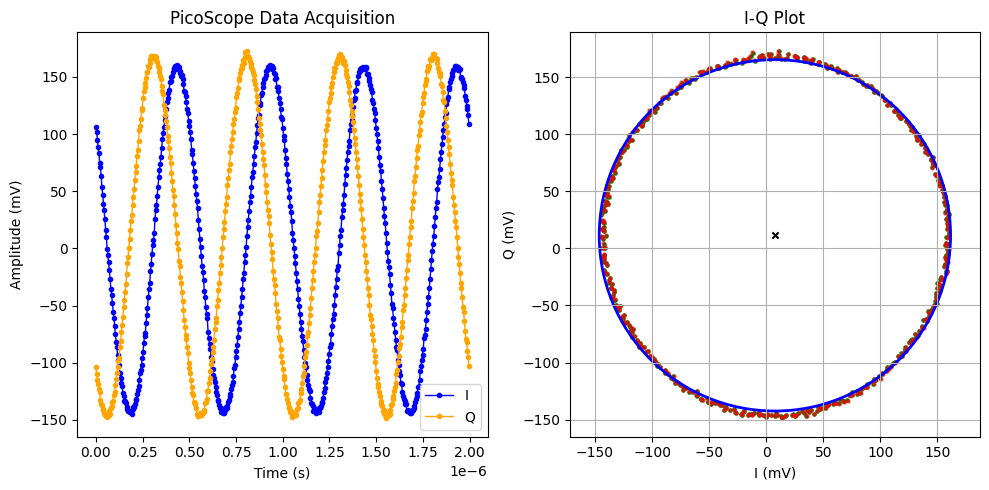

In [26]:
mean_radius = np.mean(np.sqrt(I_corrected**2 + Q_corrected**2))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, I_corrected, label=column_names[1], color='blue', linewidth=1, marker='.')
ax[0].plot(t, Q_corrected, label=column_names[2], color='orange', linewidth=1, marker='.')
ax[0].legend()
ax[0].set_title('PicoScope Data Acquisition')
ax[0].set_xlabel(f'Time ({column_units[0]})')
ax[0].set_ylabel(f'Amplitude ({column_units[1]})')

# I-Q plot
ax[1].scatter(I_corrected, Q_corrected, label='I-Q', color='green', s=5)
ax[1].scatter(I, Q, label='I-Q', color='red', s=5, alpha=0.5)
# draw center of circle
ax[1].scatter(np.mean(I), np.mean(Q), color='black', s=20, label='Center of Circle', marker='x')
# Draw circle
ax[1].add_patch(plt.Circle((np.mean(I), np.mean(Q)), mean_radius , color='blue', fill=False, lw=2))
ax[1].set_title('I-Q Plot')
ax[1].set_xlabel(f'I ({column_units[1]})')
ax[1].set_ylabel(f'Q ({column_units[2]})')
ax[1].grid(True)
ax[1].axis('equal')

fig.tight_layout()